# Monte-Carlo vs TD(0) Policy Evaluation (Random Walk Environment)

Tanto Monte-Carlo quanto o Método de Diferenças Temporais TD(0) podem ser utilizados na tarefa de Model-Free Prediction, que consiste em avaliar o comportamento de um agente em determinado MDP sem conhecimento do modelo do ambiente, somente através da experiência obtida pelo agente.

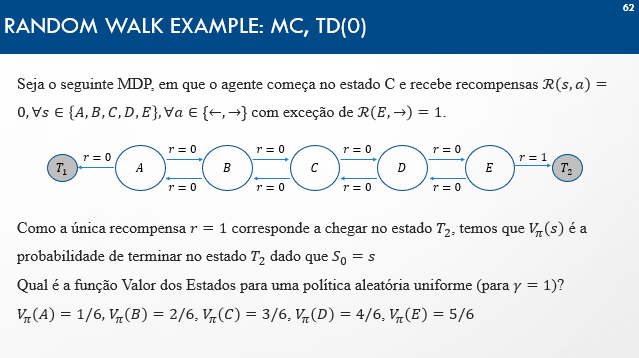

## Imports

In [15]:
import numpy as np
import matplotlib.pyplot as plt

## Environment Class

In [16]:
# CLASSES ---------------------------------------------------------------------
#--------------------------------------------
# WalkEnvironment
# PROPERTIES:
# num_states: Number of non-terminal states (left-most state is terminal
#             with r=0 and righ-most state is terminal with r=1)
# gamma: Discount Factor
# initial_state_probabilities: list of len=num_states with probabilities of starting in each state
#
# METHODS:
# __init__: Class default constructor
# step(self, state, action): Perform Environment Dynamics step given state and action
class WalkEnvironment:
    def __init__(self, num_states, gamma, initial_state_probabilities):
        self.num_states = num_states
        self.gamma = gamma
        self.initial_state_probabilities = initial_state_probabilities

        self.state_space = list(np.arange(num_states))
        self.action_space = [-1, 1]
    
    
    #------------------------------------------------------------------------------
    # step(self, state, action)
    #
    # INPUT:
    # state: Current agent position (int)
    # action: Action taken (-1: Go Left, 1: Go Right)
    #
    # OUTPUT:
    # next_state: Next agent position (1D numpy array with shape=(2,) or list)
    # reward: Immediate Reward obtained (float)
    # done: Indicates if next state is terminal (Bool)
    #------------------------------------------------------------------------------
    def step(self, state, action):
        
        if (state == 0 and action == -1):
            r = 0
            next_state = -1
            done = True
        elif (state == (self.num_states-1) and action == 1):
            r = 1
            next_state = self.num_states
            done = True
        else:
            r = 0
            next_state = state + action
            done = False
        
        return r, next_state, done
    
    
    #------------------------------------------------------------------------------
    # show(self, state)
    #
    # INPUT:
    # state: Current agent position (1D numpy array with shape=(2,) or list)
    #
    # OUTPUT:
    #------------------------------------------------------------------------------
    def show(self,state):
        states_array = np.zeros(self.num_states)
        
        states_array[state] = 1
        
        print(states_array)

### Create Environment

In [17]:
# Create Environment
env = WalkEnvironment(num_states=5, gamma=1, initial_state_probabilities=[0,0,1,0,0])

state_space = env.state_space
print('state_space = ' + str(state_space))
action_space = env.action_space
print('action_space = ' + str(action_space))

env.show(state=2)

state_space = [0, 1, 2, 3, 4]
action_space = [-1, 1]
[0. 0. 1. 0. 0.]


## Random Policy


In [18]:
n = len(state_space)
m = len(action_space)
random_policy = (1/m)*np.ones((n,m))
print('Random Policy')
print(random_policy)

Random Policy
[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]


## Transition Class

In [19]:
class Transition():
    def __init__(self,s,a,r,s_next,done):
        self.s = s
        self.a = a
        self.r = r
        self.s_next = s_next
        self.done = done

## Generate Episode

In [20]:
#------------------------------------------------------------------------------
# GenerateEpisode(env,policy)
#
# INPUT:
# env: Environment object
# policy: numpy array with shape=(n, m) with probabilities of actions given states
#
# OUTPUT:
# episode: list of Transition objects.
# returns_list: Returns G_0,G_1,...,G_{T-1}
#------------------------------------------------------------------------------
def GenerateEpisode(env, policy):
    print('Generating Episode')
    
    episode = []
    s = np.random.choice(env.state_space, p=env.initial_state_probabilities)
    
    done = False
    while (done == False):
        # Show Environment on current state
        env.show(s)
        # Obtain Action from Policy
        a = np.random.choice(env.action_space, p=policy[s,:])
        # Execute Action and observe reward + next_state
        r, s_next, done = env.step(s,a)
        # Store Transition
        transition = Transition(s,a,r,s_next,done)
        episode.append(transition)
        # Move to next_state
        s = s_next
    
    # Calculate Returns
    returns_list = []
    G=0
    for i in range(len(episode)-1,-1,-1):
        t = episode[i]
        G = env.gamma*G + t.r
        returns_list.append(G)
    returns_list = list(reversed(returns_list))
        
        
    return episode, returns_list

In [21]:
episode, returns_list = GenerateEpisode(env, random_policy)

Generating Episode
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]


## Plot Episode

In [22]:
def plot_episode(env,episode):
    for transition in episode:
        print('---------------------------')
        print('s = ')
        env.show(state=transition.s)
        print('a = ' + str(transition.a))
        print('r = ' + str(transition.r))
        print('done = ' + str(transition.done))

In [23]:
plot_episode(env,episode)

---------------------------
s = 
[0. 0. 1. 0. 0.]
a = -1
r = 0
done = False
---------------------------
s = 
[0. 1. 0. 0. 0.]
a = -1
r = 0
done = False
---------------------------
s = 
[1. 0. 0. 0. 0.]
a = -1
r = 0
done = True


## First-Visit Monte-Carlo Policy Evaluation

In [24]:
#------------------------------------------------------------------------------
# FirstVisit_MonteCarlo_PolicyEvaluation(env, policy)
#
# INPUT:
# env: Environment object
# policy: numpy array with shape=(2,env.num_states) with probabilities of actions given states
# alpha: Learning Rate (0,1]
# N_episodes: Number of Episodes
#
# OUTPUT:
# V_list: List of Value Functions at each iteration (list o numpy arrays with shape=(env.num_states))
#------------------------------------------------------------------------------
def FirstVisit_MonteCarlo_PolicyEvaluation(env, policy, alpha, N_episodes):
    V_list = []
    V_list.append(np.zeros(env.num_states))
    
    for ep in range(0,N_episodes):
        # Current V
        V_current = np.copy(V_list[-1])
        V_new = np.copy(V_current)
        # Generate Episode given policy
        episode, returns_list = GenerateEpisode(env, policy)
        # Variable to check first visit to states
        Already_Visited = [False for i in range(env.num_states)]
        # Go through states in episode
        for i in range(0,len(episode)):
            transition = episode[i]
            s = transition.s
            G = returns_list[i]
            if (Already_Visited[s] == False):
                Already_Visited[s] = True
                V_new[s] = V_current[s] + alpha*(G - V_current[s]) # Monte-Carlo alpha update
        # Append New V to list of value functions
        V_list.append(V_new)
        
    return V_list

In [25]:
V_list = FirstVisit_MonteCarlo_PolicyEvaluation(env, random_policy, alpha=0.01, N_episodes=500)

Streaming output truncated to the last 5000 lines.
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
Generating Episode
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
Generating Episode
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]
Generating Episode
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 1

## TD(0) Policy Evaluation

In [26]:
#------------------------------------------------------------------------------
# TD0_PolicyEvaluation(env, policy)
#
# INPUT:
# env: Environment object
# policy: numpy array with shape=(2,env.num_states) with probabilities of actions given states
# alpha: Learning Rate (0,1]
# N_episodes: Number of Episodes
#
# OUTPUT:
# V_list: List of Value Functions at each iteration (list o numpy arrays with shape=(env.num_states))
#------------------------------------------------------------------------------
def TD0_PolicyEvaluation(env, policy, alpha, N_episodes):
    V_list = []
    V_list.append(np.zeros(env.num_states))
    
    for ep in range(0,N_episodes):
        # Current V
        V = np.copy(V_list[-1])
        # Generate Episode given policy
        episode, returns_list = GenerateEpisode(env, policy)
        # Go through timesteps in episode
        for i in range(0,len(episode)):
            s = episode[i].s
            s_next = episode[i].s_next
            done = episode[i].done
            if (not done): # non-terminal state
                V[s] = V[s] + alpha*(episode[i].r + env.gamma*V[s_next]\
                                                     - V[s]) # TD(0) alpha update
            else: # terminal state
                V[s] = V[s] + alpha*(episode[i].r + env.gamma*0 - V[s]) # TD(0) alpha update
                
        
        # Append New V
        V_list.append(V)
        
    return V_list

In [27]:
V_list_td0 = TD0_PolicyEvaluation(env, random_policy, alpha=0.05, N_episodes=500)

Generating Episode
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]
Generating Episode
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]
Generating Episode
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]
Generating Episode
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
Generating Episode
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0.]
[0. 

## MC vs TD(0) Comparison

Streaming output truncated to the last 5000 lines.
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]
Generating Episode
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
Generating Episode
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]
Generating Episode
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
Generating Episode
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]
Generating Episode
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]
Generating Episode
[0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]
Generating Episode
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]
Generating Episode
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.

Text(0, 0.5, 'RMSE')

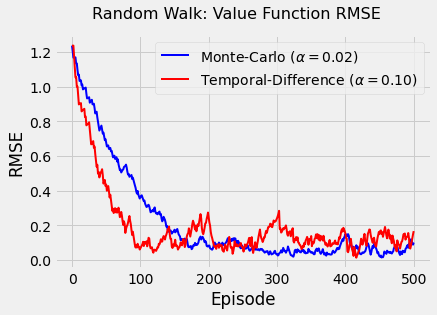

In [28]:
# Monte-Carlo Policy Evaluation
V_list_MC = FirstVisit_MonteCarlo_PolicyEvaluation(env, random_policy, alpha=0.02, N_episodes=500)

# TD(0) Policy Evaluation     
V_list_TD0 = TD0_PolicyEvaluation(env, random_policy, alpha=0.10, N_episodes=500)

# Calculate RMSE
true_v = (1/(env.num_states+1))*(1+np.arange(env.num_states))

# Monte-Carlo
RMSE_MC = []
for v in V_list_MC:
    mse = np.mean(np.sum((true_v-v)**2))
    rmse = np.sqrt(mse)
    RMSE_MC.append(rmse)
    
# Temporal-Difference
RMSE_TD0 = []
for v in V_list_TD0:
    mse = np.mean(np.sum((true_v-v)**2))
    rmse = np.sqrt(mse)
    RMSE_TD0.append(rmse)

# Plot RMSE
plt.style.use('fivethirtyeight')
fig = plt.figure()
ax = fig.gca()

ax.plot(RMSE_MC, color='b', lw=2, label='Monte-Carlo (' + r'$\alpha = 0.02$' + ')')
ax.plot(RMSE_TD0, color='r', lw=2, label='Temporal-Difference (' + r'$\alpha = 0.10$' + ')')

fig.suptitle('Random Walk: Value Function RMSE', fontsize=16)
ax.legend(loc='best')
ax.set_xlabel('Episode')
ax.set_ylabel('RMSE')